In [109]:
import contextlib
import itertools as it
import functools as ft
from io import StringIO


import torch
from torch import nn

from IPython.display import display, HTML, Image
from ipywidgets import widgets
import torchviz
from torchviz import make_dot

from time import perf_counter


In [2]:
@contextlib.contextmanager
def html_tag(t, *, dest, style=None):
    style_str = "" if style is None else f'style="{style}"'
    dest.write(f"<{t} {style_str}>")
    yield
    dest.write(f"</{t}>")

def table_html(table, styles="", default_td_style="box-shadow: 4px 2px 5px grey;"):
    res = StringIO()
    tag = ft.partial(html_tag, dest=res)
    if isinstance(styles, str): styles= it.repeat(styles)
    with tag("table", style="table-layout: fixed; border-spacing: 3px; border-collapse: separate"), tag("tbody"):
        for row, row_style in zip(table, styles):
            if isinstance(row_style, str): row_style = it.repeat(row_style)
            with tag("tr"):
                for value, style in zip(row, row_style,):
                    with tag("td", style=f"{default_td_style} {style}"):
                        res.write(value)

    return res.getvalue()

n_colors = 10
colors = [f"hsl({hue}, 70%, 80%)" for hue in range(0, 360, 360//n_colors)]
colors_styles = [f"background-color: {color}" for color in colors]

def get_style_from_color_indices(color_list):
    match color_list:
        case []:
            return "background-color: white"
        case [c]:
            c_= colors[c  % len(colors)]
            return f"background-color: {c_}"
        case [*cs]:
            n_colors = len(color_list)
            percentages = [f"{k/n_colors:.0%}" for k in range(n_colors +1)]
            s = StringIO()
            s.write("background: linear-gradient( to bottom")
            for c, p0, p1 in zip(cs, percentages[:-1], percentages[1:]):
                c_ = colors[c  % len(colors)]
                s.write(f", {c_} {p0} {p1}")
            s.write(")")
            return s.getvalue()


def display_table(table, styles=tuple()):
    display(HTML(table_html(table, styles)))

def display_tensor(tensor):
    if tensor.ndim == 1:
        tensor = tensor.unsqueeze(0)
    if torch.is_floating_point(tensor):
        display_table([[f"{i.item():.01f}" for i in r] for r in tensor], colors_styles)
    else: display_table([[str(i.item()) for i in r] for r in tensor], colors_styles)

def display_storage(tensor):
    storage = tensor.storage()
    storage_colors = [[] for _ in storage]
    for index in it.product(*[range(i) for i in tensor.shape]):
        if not len(index): continue # 0-dim tensor
        column, *_ = index
        storage_index = sum([ i * s for i, s in zip(index, tensor.stride())])
        storage_colors[storage_index].append(column)
    #print(storage_colors)
    styles = [[get_style_from_color_indices(c) for c in storage_colors]]
    #print(styles)
    if torch.is_floating_point(tensor):
        return display_table([[f"{i:.01f}" for i in storage]], styles)
    else: 
        return display_table([[str(i) for i in storage]], styles)

    


class DisplayColumns:

    def __init__(self):
        self.outputs = []

    @contextlib.contextmanager
    def column(self):
        output = widgets.Output()
        self.outputs.append(output)
        with output:
            yield

    def display(self):
        display(widgets.HBox(self.outputs))

#display_storage(w)

# Tensor Structure

In [3]:
def print_characterestics(tensor):
    print("stride: ", tensor.stride())
    print("shape: ", tuple(tensor.shape))
    print("contiguous? ", tensor.is_contiguous())

def display_tensor_and_storage(tensor):
    c = DisplayColumns()
    if tensor.ndim == 1:
        tensor = tensor[None, :]
    print()
    with c.column():
        print("tensor:")
        display_tensor(tensor)
    with c.column():
        print("storage:")
        display_storage(tensor)
    c.display()

In [89]:
t = torch.arange(12, dtype=torch.uint8)
print_characterestics(t)
display_tensor_and_storage(t)

stride:  (1,)
shape:  (12,)
contiguous?  True



In [6]:
u = t.reshape((3, 4))
print_characterestics(u)
display_tensor_and_storage(u)

stride:  (4, 1)
shape:  (3, 4)
contiguous?  True



In [7]:
u_transpose = u.T
print_characterestics(u_transpose)
display_tensor_and_storage(u_transpose)

stride:  (1, 4)
shape:  (4, 3)
contiguous?  False



## Slicing

In [8]:
u_sliced = u[:2, :]
print_characterestics(u_sliced)
display_tensor_and_storage(u_sliced)

stride:  (4, 1)
shape:  (2, 4)
contiguous?  True



In [9]:
u_sliced2 = u[:, :2]
print_characterestics(u_sliced2)
display_tensor_and_storage(u_sliced2)

stride:  (4, 1)
shape:  (3, 2)
contiguous?  False



In [10]:
t_skipping = t[::3]
print_characterestics(t_skipping)
display_tensor_and_storage(t_skipping)

stride:  (3,)
shape:  (4,)
contiguous?  False



## Broadcasting

In [11]:
# indexing with "None" means "create 1 empty dimension"
v = t[:, None]
print_characterestics(v)
display_tensor_and_storage(v)

stride:  (1, 1)
shape:  (12, 1)
contiguous?  True



In [12]:
w = v.expand(12, 5)
print_characterestics(w)
display_tensor_and_storage(w)

stride:  (1, 0)
shape:  (12, 5)
contiguous?  False



In [13]:
w_transpose = w.T
print_characterestics(w_transpose)
display_tensor_and_storage(w_transpose)

stride:  (0, 1)
shape:  (5, 12)
contiguous?  False



In [14]:
u_sliced_flat = u_sliced.flatten()
print_characterestics(u_sliced_flat)
display_tensor_and_storage(u_sliced_flat)

stride:  (1,)
shape:  (8,)
contiguous?  True



In [15]:
w_transpose_flat = w_transpose.flatten()
print_characterestics(w_transpose_flat)
display_tensor_and_storage(w_transpose_flat)

stride:  (1,)
shape:  (60,)
contiguous?  True



## Masking and indexing

Fancy indexing!



### Indexing with an array

Remember `t_skipping`


In [16]:
print_characterestics(t_skipping)
display_tensor_and_storage(t_skipping)

stride:  (3,)
shape:  (4,)
contiguous?  False




Say I want elements 0, 2, and 3  of `t_skipping`

I can just write

In [17]:
indexed = t_skipping[[0, 2, 3]]
display_tensor_and_storage(indexed)

This operations makes a copy onto a *new storage* (it couldn't work by just changing the strides / shape) 

In a more realistic case, say I want to do *message passing*, I have a node vector

In [18]:
nodes = torch.randn(5, 7)
edges = torch.randint(5, size=(4, 2))
print("nodes: ")
display_tensor_and_storage(nodes)
print()
print("edges: ")
display_tensor_and_storage(edges)

nodes: 




edges: 



In [19]:
tensor_edge_j = nodes[edges[:, 1]]
display_tensor_and_storage(tensor_edge_j)

Now we need to send it through an MLP, and aggregate into `edge[0]`… which we will see how to do later

### Masking (indexing with a boolean array)

say Now I want my nodes labels to be bounded above by $0.5$. So I want to set everything bigger than $0.5$ to $0.5$

I can easily make a boolean array indicating where nodes label values are above $0.5$

In [20]:
threshold = 0.5
threshold_mask = nodes > threshold
print("nodes: ")
display_tensor_and_storage(nodes)
print()
print("threshold mask: ")
display_tensor_and_storage(threshold_mask)

nodes: 




threshold mask: 



If I wan to get all the values that are above $0.5$ I can use this array to index !

In [21]:
above_threshold_values = nodes[threshold_mask]

display_tensor_and_storage(above_threshold_values)

# Operations

## Broadcasting


In [22]:
three = torch.tensor(3)
print_characterestics(three)
display_storage(three)

stride:  ()
shape:  ()
contiguous?  True


3


What happens if I call `torch.mul(torch.tensor(3), u)`?

Broadcasting! First `three` gets padded with dimensions of leghth `1` to have the same number of dimensions as `u`

In [23]:
three_padded = three[None, None]
print_characterestics(three_padded)
display_tensor_and_storage(three_padded)

stride:  (1, 1)
shape:  (1, 1)
contiguous?  True



Then `three` gets "broadcasted" (replicated) across the dimensions equal to 1, so that it matches the dimensions of `u`

In [24]:
three_broadcasted = three_padded.expand(u.shape)
print_characterestics(three_broadcasted)
display_tensor_and_storage(three_broadcasted)

stride:  (0, 0)
shape:  (3, 4)
contiguous?  False



Now that `three` and `u`

**Note:** This would work even if `three` was not a 0-dim tensor. In fact this is what happens when you add a vector and a matrix for example. In the general case, the rules are as follow.

*example: do an operation on a tensor of shape `[5, 12, 1, 5]` and one of shape `[3, 5]`*  

1. If one of the two tensors has fewer dimensions, pad this one at the start with dimensions of size `1`. *we now have `[5, 12, 1, 5]` and `[1, 1, 3, 5]`*

2. For all dimensions

   - if they are the same, do nothing
   - if they are different, but one is one, broadcast that one to the other
   - otherwise, fail
   
   *We now have `[5, 12, 3, 5]` and `[5, 12, 3, 5]`*

## Dispatch

Somewhere in the torch source code is a file called `native_functions.yaml` containing

```yaml
...

- func: mul.Tensor(Tensor self, Tensor other) -> Tensor
  device_check: NoCheck   # TensorIterator
  structured_delegate: mul.out
  variants: function, method
  dispatch:
    SparseCPU, SparseCUDA: mul_sparse
    SparseCsrCPU, SparseCsrCUDA: mul_sparse_csr
    MkldnnCPU: mkldnn_mul
    ZeroTensor: mul_zerotensor
    NestedTensorCPU, NestedTensorCUDA: NestedTensor_mul_Tensor
  tags: [core, pointwise]

...

- func: mul.out(Tensor self, Tensor other, *, Tensor(a!) out) -> Tensor(a!)
  device_check: NoCheck   # TensorIterator
  structured: True
  structured_inherits: TensorIteratorBase
  dispatch:
    CPU, CUDA: mul_out
    MPS: mul_out_mps
    SparseCPU: mul_out_sparse_cpu
    SparseCUDA: mul_out_sparse_cuda
    SparseCsrCPU, SparseCsrCUDA: mul_out_sparse_csr
    MkldnnCPU: mkldnn_mul_out
  tags: pointwise
  # For C++ only, until we have conversion from C++ numbers to Tensor

```

which basically tells `torch` that when calling `torch.mul` on `CPU` or `CUDA`, it should call the `mul_out` function

*Note:* why is it the same function for CPU and CUDA? It actually isn't, it's two function that have the same name, but live in two different shared object libraries

## GPU and asynchronicity

### What is a CUDA Tensor?

- A tensor whose **storage** lives in gpu memory
- The stride / shape are still on CPU memory! no need to access

*Note:* this is not `pytorch` specific, the CUDA programming API handles these kind of things. Relevant is section 3.5.2 of the CUDA programming guide

In [28]:
t_gpu = t.to("cuda:0")
t_gpu.storage().device

device(type='cuda', index=0)

![Trace](images/profiler_screenshot.png)

In [74]:
random_tensor = torch.randn(size=(50000,)).pin_memory() # puts t in a special piece of memory that can be read from by the GPU

t0 = perf_counter()

random_tensor_cuda = random_tensor.to("cuda:0", non_blocking=True) # tells the GPU to copy the tensor to gpu memory

for i in range(10):
    random_tensor_cuda = random_tensor_cuda[None, :] * random_tensor_cuda[:, None] # tells the GPU to launch a multiplication
    random_tensor_cuda = random_tensor_cuda.sum(-1)
    

t1 = perf_counter()

random_tensor_cuda.to("cpu")

t2 = perf_counter()

t1 - t0, t2 - t1

(0.040832958882674575, 0.26867834804579616)

**Why is the data transfer taking so long?**

In [75]:
random_tensor = torch.randn(size=(50000,)).pin_memory() # puts t in a special piece of memory that can be read from by the GPU

t0 = perf_counter()

random_tensor_cuda = random_tensor.to("cuda:0", non_blocking=True) # tells the GPU to copy the tensor to gpu memory

for i in range(10):
    random_tensor_cuda = random_tensor_cuda[None, :] * random_tensor_cuda[:, None] # tells the GPU to launch a multiplication
    random_tensor_cuda = random_tensor_cuda.sum(-1)

torch.cuda.synchronize() # actually waits for all those operations to be finished ! "sychronizes"

t1 = perf_counter()

random_tensor_cuda.to("cpu") 

t2 = perf_counter()
t1 - t0, t2 - t1

(0.29398595402017236, 0.0010703420266509056)

**Note:** I chose this operation because it is pretty long even on a tensor of this size. *data transfers* and *calls* have non-negligible overhead otherwise

# Autograd

In [104]:
t = torch.arange(12, dtype=torch.float32)
t.requires_grad_(True)
print_characterestics(t)
display_tensor_and_storage(t)

stride:  (1,)
shape:  (12,)
contiguous?  True



In [105]:
t = t + 2
t

tensor([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.],
       grad_fn=<AddBackward0>)

In [106]:
u = torch.randn(12)
t = t * u
t

tensor([ -0.8347,  -2.3018,   4.7768, -11.0385,   4.5738,   6.9467,  11.5775,
         -8.5604,  -6.9612,  12.0964,   1.1939, -11.1874],
       grad_fn=<MulBackward0>)

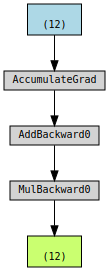

In [107]:
make_dot(t)

What about a more complicated example (taken directly from the [torchviz readme](https://github.com/szagoruyko/pytorchviz#usage)

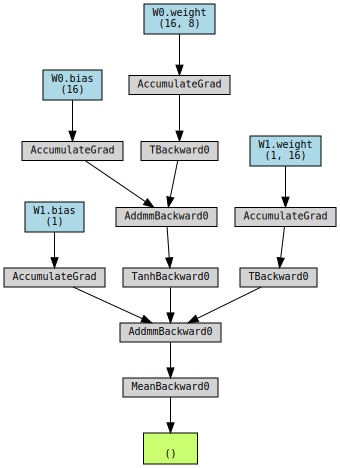

In [110]:
model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = torch.randn(1, 8)
y = model(x)

make_dot(y.mean(), params=dict(model.named_parameters()))

Backward computations are typically hard to debug, because a lot of it is done in C code, which sometimes itself calls Python code. There is a file in the `torch` source called `derivatives.yaml` which maps every native function to its derivative

**Note:** it is possible to define a custom function with a custom backward all in Python ! For example

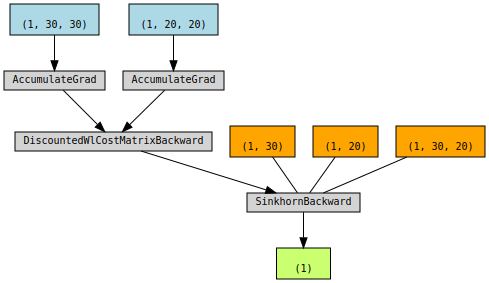

In [115]:
from ot_markov_distances import discounted_wl_infty
import networkx as nx
from ot_markov_distances.discounted_wl import discounted_wl_infty
from ot_markov_distances.utils import weighted_transition_matrix

# generate dummy graphs
G1 = nx.erdos_renyi_graph(30, .1, directed=True)
G2 = nx.erdos_renyi_graph(20, .15, directed=True)

# make them into markov transition matrices (with self-transition probability q=0.)
# the unsqueeze call is to create the batch dimension
M1 = weighted_transition_matrix(G1, q=0.).unsqueeze(0)
M2 = weighted_transition_matrix(G2, q=0.).unsqueeze(0)

M1.requires_grad_(True)
M2.requires_grad_(True)

# use the uniform distribution. This has given the stablest results in our experiments
# as opposed to the default, the stationary distribution of the markov chain
mu1 = torch.ones(1, 30,) /  30
mu2 = torch.ones(1, 20,) /  20

# and a random distance matrix (simulated here as the distance between random labels of size 5)
C = torch.cdist(torch.rand(1, 30, 5), torch.rand(1, 20, 5))

distance = discounted_wl_infty(M1, M2, C, muX=mu1, muY=mu2)

make_dot(distance)

# Scatter and segment / Pytorch-geometric style indexing

## Scatter

Remember when we wanted to do message passing? we had  


In [77]:
nodes = torch.randn(5, 7)
edges = torch.randint(5, size=(4, 2))
print("nodes: ")
display_tensor_and_storage(nodes)
print()
print("edges: ")
display_tensor_and_storage(edges)

nodes: 




edges: 



In [ ]:
tensor_edge_j = nodes[edges[:, 1]]
display_tensor_and_storage(tensor_edge_j)

To do this, we can do a scatter operation:

`scatter(src, index)`

<div>
    <img src="https://raw.githubusercontent.com/rusty1s/pytorch_scatter/master/docs/source/_figures/add.svg?sanitize=true" width=500 />
</div>

This type of operation is available in the [pytorch scatter](https://pytorch-scatter.readthedocs.io/en/latest/index.html) library (that pytorch-geometric uses), and `torch` also has primitives for this, although harder to use

In [ ]:
from torch_scatter import scatter, segment_coo
post_message_passing = scatter(tensor_edge_j, index=edges[:, 0], dim=0)

display_tensor_and_storage(post_message_passing)

## Segment

This is a more optimized version of scatter, that needs the groups to be contiguous

<div>
    <img src="https://raw.githubusercontent.com/rusty1s/pytorch_scatter/master/docs/source/_figures/segment_coo.svg?sanitize=true" width=500 />
</div>


This is useful for networks such as `deepsets` where you are working on sets of different sizes, where you can stack the sets in a contiguous fashion.

There is a more optimized version of that primitive that uses a `ptr` array that indicates the starts of each group. In that example, `ptr = [0, 3, 4, 6, 8]`

# Attention

## Classic attention

In [122]:
key_dim = 64
value_dim = 10
sequence_length = 512

Q = torch.randn((sequence_length, key_dim), device = "cuda:0")
K = torch.randn((sequence_length, key_dim), device = "cuda:0")
V = torch.randn((sequence_length, value_dim), device = "cuda:0")

att_logits = Q @ K.T # sequence_length, sequence_length
att_weights = torch.softmax(att_logits, dim=-1) # sequence_length, sequence_length

att_results = att_weights @ V # sequence_length, value_dim
